# Introduction

I found this dataset rather cute so I tried to make a deep learning model to predict the breed of the dog

I used transfer learning, basically I took an already trained model and added layers to it, and trained it on this dataset.

The model I chose is the VGG16, trained on the Imagenet dataset.

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import time

import matplotlib.pyplot as plt

import cv2

## Loading the images and preprocessing

I chose to load all images into memory, but if you don't have enough memory (around 9.3GB) you can use the generator from keras https://keras.io/preprocessing/image/.

Further we have to preprocess the image to fit the VGG16 model. The model expects a 224 by 224 RGB image.


In [26]:
BASEPATH = "data/stanford-dogs-dataset/Images/"

LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH):
    LABELS.add(d)
    paths.append((BASEPATH+d, d))

In [27]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [28]:
X = []
y = []

for path, label in paths:
    for image_path in os.listdir(path):
        image = load_and_preprocess_image(path+"/"+image_path)
        
        X.append(image)
        y.append(label)

### Encoding the labels

Every model I know of, can only work with numbers, therefore we need to create our label (n02096294-Australian_terrier) to an integer array. This is called **one-hot-encoding**

In [29]:
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

print(X[0].dtype)
print(y[0])

uint8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


(20580, 224, 224, 3)
(20580, 120)


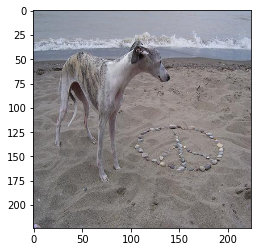

In [30]:
print(X.shape)
print(y.shape)
plt.imshow(X[0])

## Training and evaluating

Now comes to most interesting part. Training and evaluating our model

First step is to create a training and testing dataset

After this I have 2 approaches.
- Creating our own model, which I tried
- Using transfer learning on the VGG16 model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

This is the own model I tried. I have to say I did not have a great succes with it. Maybe it needs more finetuning.

In [ ]:
model = Sequential()

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(len(LABELS),activation="softmax"))

This is the transfer learning model

I used the VGG16 with the Imagenet weights and did not include the top, so I can add my own top. Being 3 Dense Layers with relu activation, and the last one with softmax and number of neurons is the amount of labels we have.

I set the last 7 layers to trainable, which are the Dense layers I added myself. I don't want to train any layers I get from the pretrained VGG16 model.

In [55]:
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(2048,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
preds=Dense(len(LABELS),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-7]:
    layer.trainable=False
for layer in model.layers[-7:]:
    layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [56]:
early_stopping = EarlyStopping(patience=10, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

### Model training

I used the Adam optimizer, typically my first choice.

I trained the model on 50 epochs, with a batch size of 64, I used two callbacks. Early stopping to stop the training of the validation loss does not improve for 5 epochs, and Reduce LR on plateau to reduce the learning rate to 10% if the validation loss doesn't improve for 3 epochs.

In [57]:
model.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test), 
          callbacks=[early_stopping, reduce_lr])

Train on 18522 samples, validate on 2058 samples
Epoch 1/50
18522/18522 [==============================] - 90s 5ms/sample - loss: 4.5039 - acc: 0.0709 - val_loss: 2.8925 - val_acc: 0.2799
Epoch 2/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 2.9753 - acc: 0.2342 - val_loss: 2.2694 - val_acc: 0.4072
Epoch 3/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 2.5361 - acc: 0.3131 - val_loss: 2.0610 - val_acc: 0.4519
Epoch 4/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 2.3142 - acc: 0.3645 - val_loss: 1.9295 - val_acc: 0.4776
Epoch 5/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 2.1885 - acc: 0.3916 - val_loss: 1.8516 - val_acc: 0.5087
Epoch 6/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 2.0586 - acc: 0.4211 - val_loss: 1.8088 - val_acc: 0.5092
Epoch 7/50
18522/18522 [==============================] - 89s 5ms/sample - loss: 1.9779 - acc: 0.4407 - val_loss: 1.7

### Evaluation

Last step should always be to evaluate your model

In [62]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print("loss on the test set is {:.2f}".format(loss))
print("accuracy on the test set is {:.3f}".format(acc))

loss on the test set is 1.46
accuracy on the test set is 0.608


As we can see the accuracy on the test set is over 50% maybe by tuning the model and the hyperparameters we could increase this.

In [63]:
predictions = model.predict(X_test)

In [64]:
label_predictions = encoder.inverse_transform(predictions)

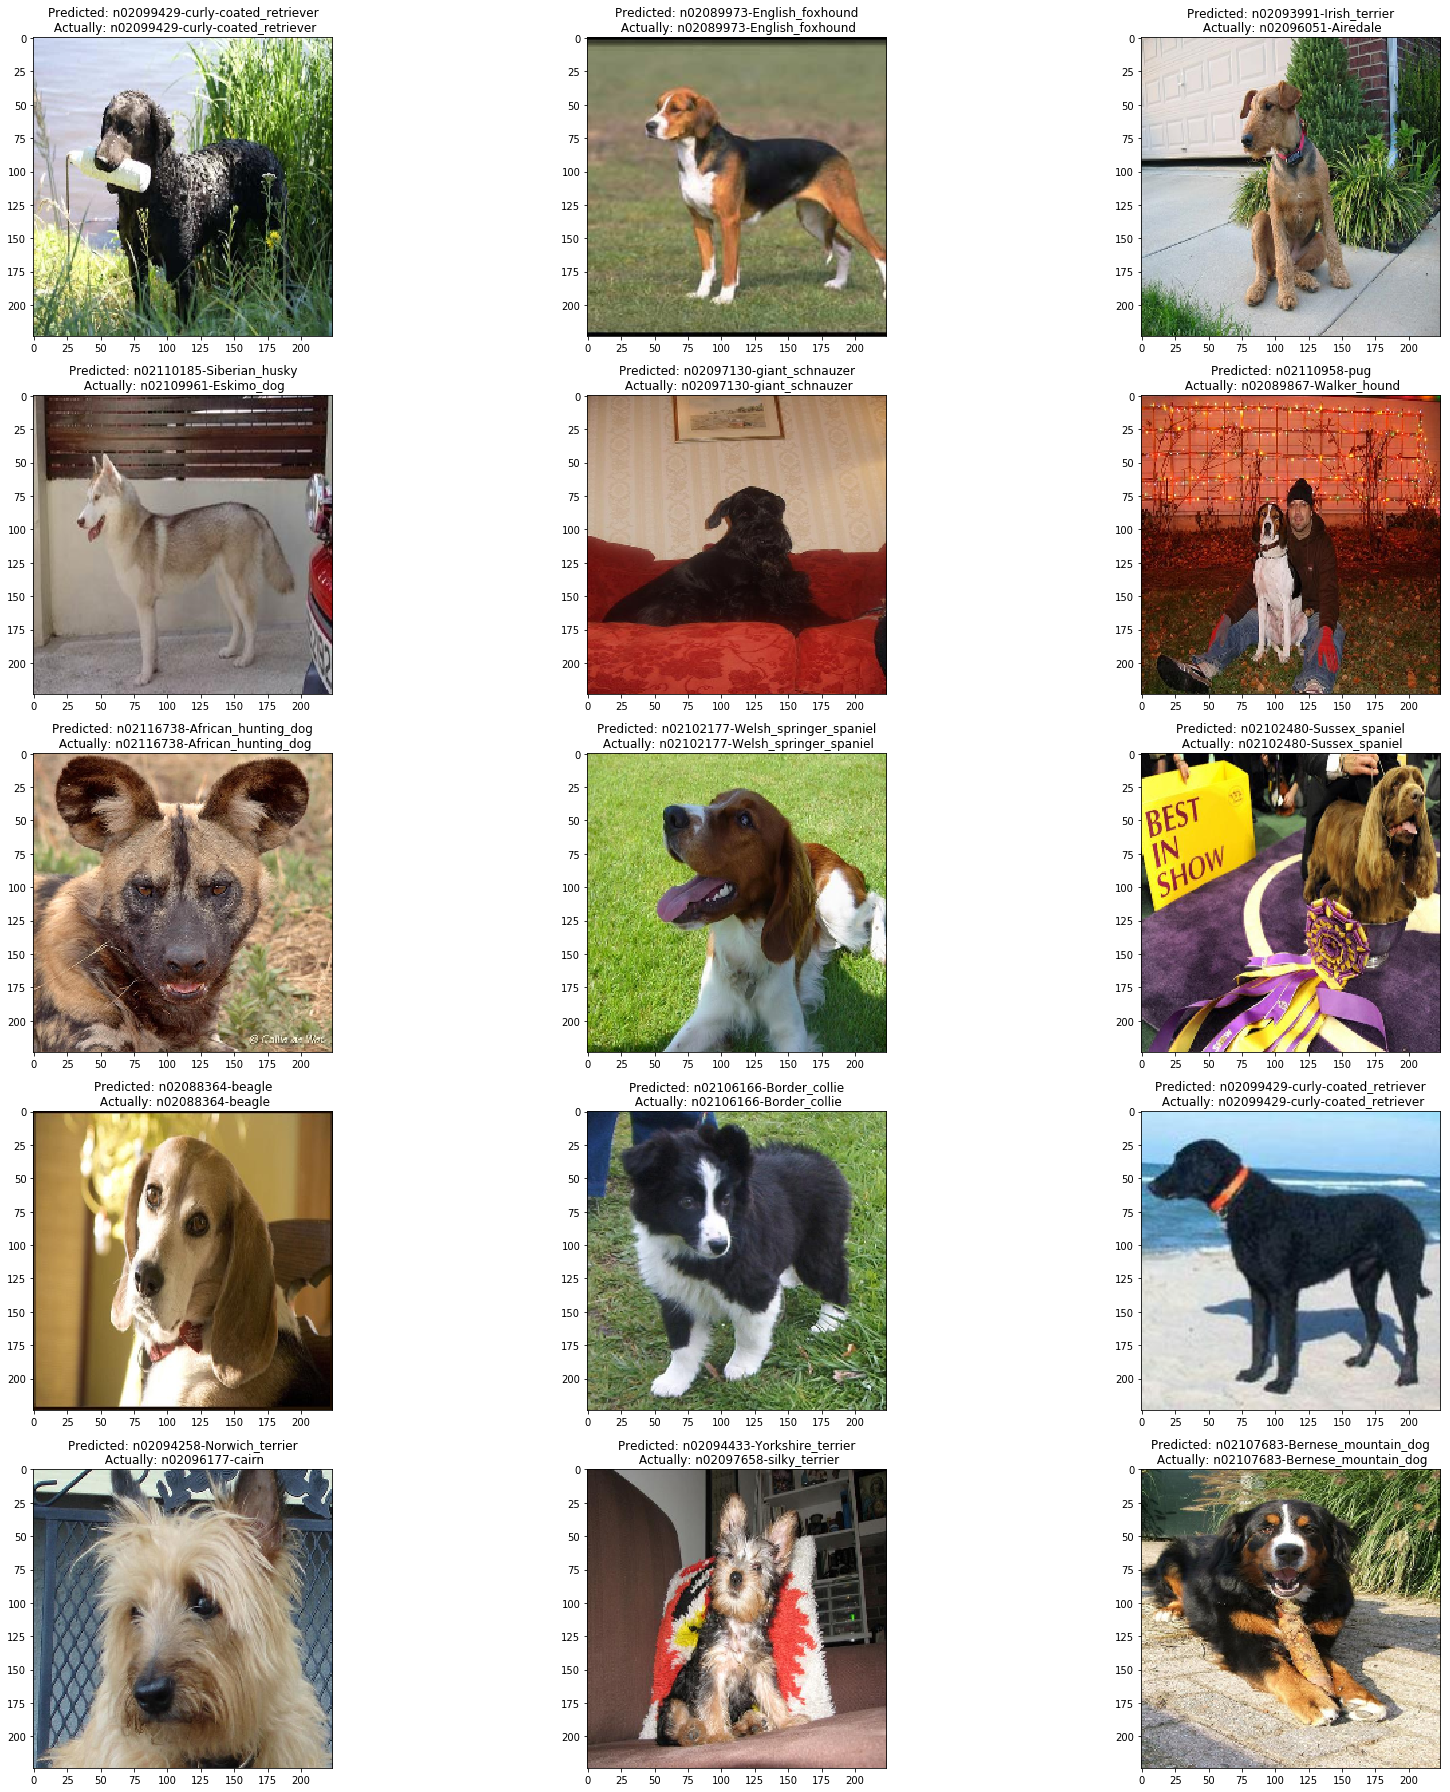

In [66]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title('Predicted: {}\n Actually: {}'
                          .format(label_predictions[index], encoder.inverse_transform(y_test)[index]))
        
plt.tight_layout()

# Using the ImageDataGenerator

Now I tried the results with the ImageDataGenerator. This allows us to scale the pixels from a value between 0-255 down to 0-1, this usually works better for deep learning algorithms. Furthermore I added two image generation methods, zooming and horizontal flip. This increases the dataset and therefore allows us to work with more data and get better results. Hopefully!

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   validation_split=0.2)

In [6]:
batch_size = 128

train_generator = train_datagen.flow_from_directory(
    BASEPATH,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    BASEPATH, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 50, callbacks=[early_stopping, reduce_lr])

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
129/129 [==============================] - 261s 2s/step - loss: 4.6915 - acc: 0.0176 - val_loss: 4.4001 - val_acc: 0.0327
Epoch 2/50
129/129 [==============================] - 241s 2s/step - loss: 4.1060 - acc: 0.0612 - val_loss: 3.7582 - val_acc: 0.1083
Epoch 3/50
129/129 [==============================] - 240s 2s/step - loss: 3.6548 - acc: 0.1139 - val_loss: 3.5288 - val_acc: 0.1388
Epoch 4/50
129/129 [==============================] - 240s 2s/step - loss: 3.4107 - acc: 0.1549 - val_loss: 3.3535 - val_acc: 0.1677
Epoch 5/50
129/129 [==============================] - 240s 2s/step - loss: 3.2506 - acc: 0.1806 - val_loss: 3.2477 - val_acc: 0.1798
Epoch 6/50
129/129 [==============================] - 241s 2s/step - loss: 3.1220 - acc: 0.2034 - val_loss: 3.1261 - val_acc: 0.2041
Epoch 7/50
129/129 [==============================] - 241s 2s/ste

## Evaluation

In [13]:
loss, acc = model.evaluate_generator(validation_generator,verbose=0)

In [17]:
print(loss,acc)
#print(f"loss on the test set is {loss:.2f}")
#print(f"accuracy on the test set is {acc:.3f}")

2.6710992753505707 0.33202356


In [10]:
predictions = model.predict_generator(validation_generator)

NameError: name 'encoder' is not defined

In [11]:
predictions

array([[5.01862681e-03, 1.35878678e-02, 5.84158711e-02, ...,
        9.82252765e-04, 1.18811462e-04, 1.06243919e-04],
       [5.21790722e-10, 7.51390772e-08, 9.25380945e-08, ...,
        9.25014376e-09, 8.06528710e-09, 4.09361824e-08],
       [2.60171189e-04, 6.65850803e-06, 1.37960978e-06, ...,
        3.73664522e-03, 1.37669279e-03, 1.53307598e-02],
       ...,
       [1.48904242e-03, 1.53790802e-06, 1.27401407e-04, ...,
        3.17899801e-04, 4.10688262e-05, 1.14272634e-05],
       [3.23142018e-03, 1.13431895e-02, 4.24724212e-03, ...,
        6.37218310e-03, 2.59050122e-03, 5.45224117e-04],
       [4.26332826e-06, 3.28940805e-05, 7.34355068e-03, ...,
        2.78054067e-05, 8.99226052e-06, 9.83871686e-08]], dtype=float32)

In [ ]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()

In [25]:
model.save('./generator_trained_model.hdf5')